# Particle swarm optimization of a polarization beam splitter

**Note: the cost of running the entire notebook is larger than 10 FlexCredits.**

[Particle Swarm Optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization) (PSO) is a powerful and versatile optimization technique. PSO has since emerged as a popular metaheuristic algorithm for solving complex optimization problems across a wide range of domains, including integrated photonic device design. At its core, PSO embodies the principles of collaboration and information sharing within a population of simple entities known as "particles." These particles navigate through a multi-dimensional search space, seeking optimal solutions to a given problem. They learn from their own experiences, as well as the experiences of other particles, to adapt their positions and velocities over time. 

In this notebook, we demonstrate the PSO of a compact polarization beam splitter (PBS) using `Tidy3D` and the [PySwarms](https://pyswarms.readthedocs.io/en/latest/index.html) library. The coupling region is segmented into 10 sections with varying widths $W_1$, $W_2$, ..., $W_{10}$. Since performing the traditional parameter sweep is unrealistic in this case due to the large parameter space dimension, we use PSO to optimize all the widths to maximize the beam splitting of the TE0 mode and the TM0 mode. The device is inspired by the work `Weiwei Chen, et al., "Ultra-compact and low-loss silicon polarization beam splitter using a particle-swarm-optimized counter-tapered coupler," Opt. Express 28, 30701-30709 (2020)`[DOI:10.1364/OE.408432](https://doi.org/10.1364/OE.408432). In the original work, the authors employed a more complex PSO scheme of changing objective functions. For the sake of simplicity, we will use a simpler PSO scheme in this notebook, only aiming to demonstrate the idea and workflow. Tidy3D users can draw inspiration from this notebook, as well as from the wealth of PSO research in the literature. By harnessing the versatility of PSO in combination with the exceptional speed of `Tidy3D`, we anticipate that users can design many novel and high-performance photonic devices.

<img src="img/particle_swarm_optimization_pbs.png" width="500" alt="Schematic of the polarization beam splitter">

Besides the PSO introduced in this notebook, Tidy3D also provides a built-in adjoint optimization plugin. Unlike PSO, adjoint optimization is gradient-based and thus more efficient. To learn more, please refer to the adjoint optimizations of a [wavelength division multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin9_WDM/), a [mode converter](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/), and a [waveguide taper](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin5BoundaryGradients/). If you are new to adjoint optimization, please start with the [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/) on adjoint basis and our [video lectures](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) on inverse design.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gdstk
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import plot_cost_history

import tidy3d as td
import tidy3d.web as web

## Preparational Work Before the PSO

### Define Fixed Simulation Settings

Before we can perform the PSO, we need to prepare a few things. First of all, we will define parts that are unchanged in the optimization procedure. The wavelength range of interest in this case is 1500 nm to 1600 nm.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 31)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (freqs[0] - freqs[-1])  # width of the source frequency range

For simplicity, we use a constant refractive index for silicon and silicon oxide. Dispersive models can certainly be used instead if needed.

In [3]:
n_si = 3.48  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.44  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)

Define geometric parameters outside of the optimization region. 

In [4]:
Ls = 0.5  # length of each segment
W0 = 0.45  # width of the input waveguide
Wa = 0.2  # width of the taper tip
Wt = 0.45  # width of the taper end
Hc = 0.22  # thickness of the Si layer
G0 = 0.27  # size of the gap
buffer = 8  # buffer spacing
M = 10  # number of segments to be optimized

Next, we define the device geometry outside the optimization region. These geometries will stay unchanged in the optimization process. After each part is defined, we can perform a union operation (+) to combine them together. 

In [5]:
# define the input straight waveguide geometry
input_waveguide_geo = td.Box.from_bounds(rmin=(-buffer, 0, -Hc / 2), rmax=(0, W0, Hc / 2))

# define the bar port straight waveguide geometry
bar_waveguide_geo = td.Box.from_bounds(
    rmin=((M + 1) * Ls, 0, -Hc / 2), rmax=((M + 1) * Ls + buffer, W0, Hc / 2)
)

# define the lower waveguide geometry with the help of gdstk
cell = gdstk.Cell("lower_waveguide")
path = gdstk.RobustPath(
    initial_point=(0, -G0 - Wa / 2), width=Wa, tolerance=1e-4, layer=1, datatype=0
)
path.segment(xy=((M + 1) * Ls, -G0 - Wt / 2), width=Wt, offset=-(Wt - Wa))
bend_length = 6
bend_height = 1
path.segment(
    xy=((M + 1) * Ls + bend_length, -G0 - Wt / 2),
    offset=lambda u: bend_height * np.cos(np.pi * (u)) / 2 - bend_height / 2,
)
path.horizontal(x=(M + 1) * Ls + bend_length + buffer)
cell.add(path)
lower_waveguide_geo = td.Geometry.from_gds(cell, gds_layer=1, axis=2, slab_bounds=(-Hc / 2, Hc / 2))

# perform a union operation to combine all the geometries
unchanged_geo = input_waveguide_geo + bar_waveguide_geo + lower_waveguide_geo

To visually inspect if the above-defined geometries are correct, we can simply use the `plot()` method. The geometries do look correct. The missing design region will be optimized by PSO later.

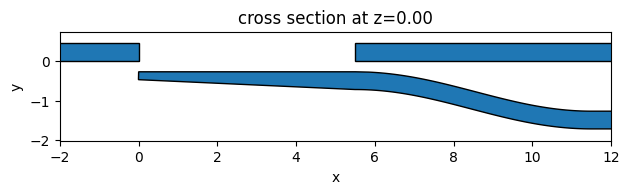

In [6]:
ax = unchanged_geo.plot(z=0)
ax.set_xlim(-2, 12)
plt.show()

### Define Design Region

Next we define a function that creates the geometry of the design region. This region is parameterized by 10 parameters $W_1$, $W_2$, ..., $W_{10}$. We will define an array `Ws` to store these 10 values. The geometry of the design region is defined as a [PolySlab](../_autosummary/tidy3d.PolySlab.html), whose vertices can be easily calculated from `Ws`.

In [7]:
def define_optimize_region(Ws):
    vertices = [(0, 0), (0, W0)]
    for i, Wi in enumerate(Ws):
        vertices.append(((i + 1) * Ls, Wi))

    vertices.append(((M + 1) * Ls, W0))
    vertices.append(((M + 1) * Ls, 0))

    optimize_region_geo = td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-Hc / 2, Hc / 2))

    return optimize_region_geo

Again, we want to visually inspect if the `define_optimize_region` function works correctly. To do so, we define `Ws` with some random values and plot the design region geometry together with the unchanged region geometries. From the plot, we can confirm that the geometries are generated correctly. 

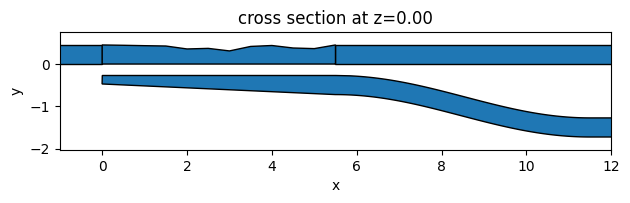

In [8]:
Ws = np.random.uniform(0.3, 0.45, M)
optimize_region_geo = define_optimize_region(Ws)

device = td.Structure(geometry=unchanged_geo + optimize_region_geo, medium=si)
ax = device.plot(z=0)
ax.set_xlim(-1, 12)
plt.show()

### Define Source and Monitors

To characterize the performance of the PBS, we need to perform two simulations: 1. excite the input waveguide with a TE0 [ModeSource](../_autosummary/tidy3d.ModeSource.html) and calculate the TE0 mode transmission at the bar port using a [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html); 2. Excite the input waveguide with a TM0 [ModeSource](../_autosummary/tidy3d.ModeSource.html) and calculate the TM0 mode transmission at the cross port using a [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html). Since the PBS is surrounded by SiO$_2$, there is a symmetry that can be exploited in the $z$ direction. We can use this symmetry to strategically select TE0 mode or the TM0 mode at the [ModeSource](../_autosummary/tidy3d.ModeSource.html) (more on it later). Therefore, here we set `num_modes=1` in the [ModeSpec](../_autosummary/tidy3d.ModeSpec.html). If no symmetry is used, `num_modes=2` should be used.

In [9]:
# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)
mode_source = td.ModeSource(
    center=(-lda0 / 2, W0 / 2, 0),
    size=(0, 4 * W0, 6 * Hc),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a mode monitor at the bar port
mode_monitor_bar = td.ModeMonitor(
    center=((M + 1) * Ls + bend_length + lda0 / 2, W0 / 2, 0),
    size=mode_source.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="bar",
)

# add a mode monitor at the cross port
mode_monitor_cross = td.ModeMonitor(
    center=((M + 1) * Ls + bend_length + lda0 / 2, -G0 - Wt / 2 - bend_height, 0),
    size=mode_source.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="cross",
)

# simulation domain box
sim_box = td.Box.from_bounds(rmin=(-1, -3.5, -1), rmax=(12.5, 1.5, 1))

# simulation run time
run_time = 5e-13

### Define Tidy3D Simulation

Next, we define a function `make_sim` that takes the design parameters and polarization and returns a Tidy3D [Simulation](../_autosummary/tidy3d.Simulation.html). If we want to define a TE0 mode excitation, we set `symmetry` to `(0,0,1)` while for TM0 excitation, we have `symmetry=(0,0,-1)`. Note again that we can use symmetry because the PBS is surrounded by silicon oxide. If no cladding is used, this symmetry will be broken and we need to define the excitation mode at the source differently. 

In [10]:
def make_sim(Ws, pol):
    optimize_region_geo = define_optimize_region(Ws)

    # define the structure for the entire PBS
    device = td.Structure(geometry=unchanged_geo + optimize_region_geo, medium=si)

    # define symmetry according to excitation polarization
    pol_to_symmetry = {"TE": (0, 0, 1), "TM": (0, 0, -1)}

    try:
        symmetry = pol_to_symmetry[pol]
    except KeyError:
        raise ValueError("Polarization can either be TE or TM")

    # add mode monitor according to excitation polarization
    if pol == "TE":
        monitor = [mode_monitor_bar]
    elif pol == "TM":
        monitor = [mode_monitor_cross]

    # define simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=10, wavelength=lda0),
        structures=[device],
        sources=[mode_source],
        monitors=monitor,
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=sio2,
        symmetry=symmetry,
    )

    return sim

We again inspect the simulation setup by plotting it. For the TM simulation, we see the [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html) at the cross port. For TE simulation, we should see the monitor at the bar port.

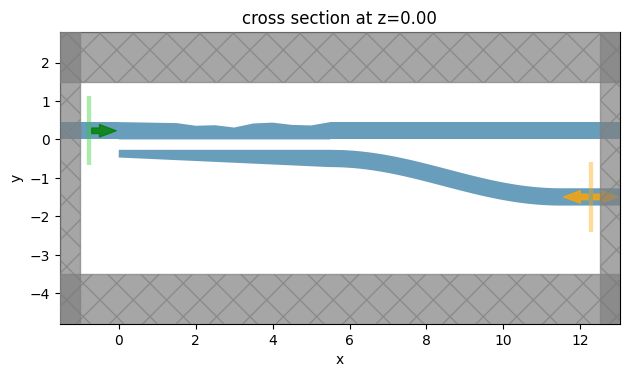

In [11]:
sim = make_sim(Ws, "TM")
sim.plot(z=0)
plt.show()

### Define the Figure of Merit (FOM)

Defining the figure of merit (FOM) is the most important step in any optimization task. We need to define a function that calculates the FOM. This function will be repeatedly called in the PSO for each iteration. In the case of the PBS, we define the FOM as the sum of $P_{TE,bar}$ and $P_{TM,cross}$, where $P_{TE,bar}$ is the transmission of TE0 mode at the bar port and $P_{TM,cross}$ is the transmission of TM0 mode at the cross port. In this particular case, we only optimize the transmission at the central frequency. If broadband operation is desired, the FOM can be defined with respect to the entire frequency range. 

For this function, the input `x` is an array with size $(N,M)$, where $N$ is the number of particles and $M$ is the dimension of the parameter space. For each particle, we need to run two simulations. Therefore, in each iteration, we need to run $2N$ simulations. The entire optimization requires $2NM$ simulations. To harness the benefit of concurrent run in Tidy3D, we put the $2N$ simulations into a [Batch](../_autosummary/tidy3d.web.Batch.html). Note that the final FOM is $-(P_{TE,bar}+P_{TM,cross})$ since the optimizer we will be using minimizes the FOM instead of maximizing it.

In [12]:
def FOM(x):
    fom = []
    sims = {}

    # define simulations for all particles
    for i in range(x.shape[0]):
        Ws = x[i, :]
        sims[f"particle {i} TE"] = make_sim(Ws, "TE")
        sims[f"particle {i} TM"] = make_sim(Ws, "TM")

    # define a batch
    batch = web.Batch(simulations=sims, verbose=False)

    # submit the batch to the server
    batch_results = batch.run(path_dir="data")

    # compute fom
    for i in range(x.shape[0]):
        # extract te transmission at bar port at the central frequency
        P_TE_bar = (
            np.abs(
                batch_results[f"particle {i} TE"]["bar"].amps.sel(
                    mode_index=0, direction="+", f=freq0
                )
            )
            ** 2
        )

        # extract tm transmission at cross port at the central frequency
        P_TM_cross = (
            np.abs(
                batch_results[f"particle {i} TM"]["cross"].amps.sel(
                    mode_index=0, direction="+", f=freq0
                )
            )
            ** 2
        )

        fom.append(-float(P_TE_bar + P_TM_cross))

    return np.array(fom)

## Performing PSO 

With all the preparation work done, we are finally ready to perform the PSO. In this notebook, we use the [PySwarms](https://pyswarms.readthedocs.io/en/latest/index.html) library, where an optimizer implementing the PSO algorithm can be directly used. With this optimizer, we can perform a PSO task very easily. 

In this optimization, we put an upper and lower bound for the $W_i$ to be 450 nm and 300 nm. 5 particles are used for a total of 40 iterations. As discussed above, this means the entire optimization will run 400 simulations and cost 10 FlexCredits. Since this notebook is mainly for demonstration purposes, the numbers of particles and iterations are kept small. To really achieve a design with high performance, larger numbers should be used. To ensure the final result is reproducible every time we run the notebook, the initial positions of the particles are fixed with a random seed.

There are three hyperparameters in PSO, namely the inertia weight `w`, the cognitive coefficient `c1`, and the social coefficient `c2`. Their values can significantly impact the performance of the algorithm. The best values of them depend on the specific problem so can take some experimentation to determine. 

In [13]:
W_max = 0.45  # upper bound
W_min = 0.3  # lower bound
bounds = (W_min * np.ones(M), W_max * np.ones(M))

options = {"c1": 1, "c2": 1, "w": 0.7}  # pso hyperparameters

n_particles = 5  # number of particles

# generate initial particle positions
np.random.seed(1)
init_pos = np.random.uniform(W_min, W_max, (n_particles, M))

# define optimizer
optimizer = GlobalBestPSO(
    n_particles=n_particles, dimensions=M, options=options, bounds=bounds, init_pos=init_pos
)

Run the PSO optimization.

In [14]:
fom, W_opt = optimizer.optimize(FOM, iters=40)

2023-09-15 12:32:58,328 - pyswarms.single.global_best - INFO - Optimize for 40 iters with {'c1': 1, 'c2': 1, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|40/40, best_cost=-1.72
2023-09-15 13:11:35,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7222590530671655, best pos: [0.35164067 0.40031427 0.36204791 0.39216045 0.39620902 0.34603939
 0.32504735 0.30598732 0.33310709 0.34670291]


After the optimization is complete, plot the FOM as a function of iteration. 

The best parameters are [0.35164067 0.40031427 0.36204791 0.39216045 0.39620902 0.34603939
 0.32504735 0.30598732 0.33310709 0.34670291].


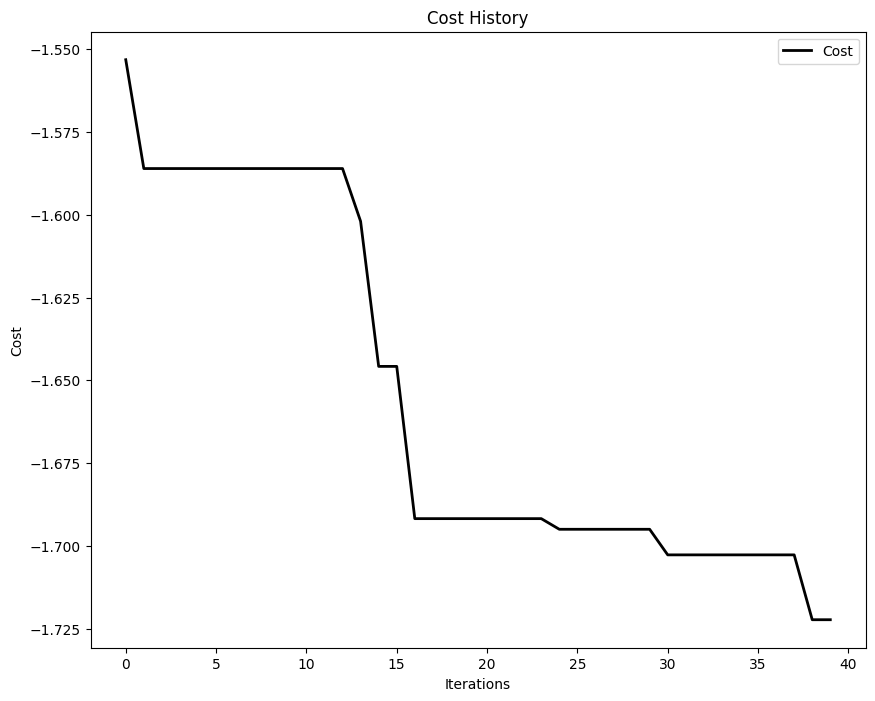

In [15]:
print(f"The best parameters are {W_opt}.")
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

## Final Optimized Design 

Finally, we will run two simulations again with the optimized parameters. We will add a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) to help visualize the mode splitting. 

In [16]:
# define a field monitor to help visualize the field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# define simulations with the optimal design
sims = {
    "TE": make_sim(W_opt, "TE").copy(
        update={"monitors": [mode_monitor_bar, mode_monitor_cross, field_monitor]}
    ),
    "TM": make_sim(W_opt, "TM").copy(
        update={"monitors": [mode_monitor_bar, mode_monitor_cross, field_monitor]}
    ),
}

# define and submit the batch
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")

[13:11:36] WARNING: Default value for the field monitor           ]8;id=744946;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\components\monitor.py\monitor.py]8;;\:]8;id=224313;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\components\monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           Created task 'TE' with task_id                          ]8;id=276857;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=809923;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           'fdve-60c9fabe-eb20-4f01-be8f-d55ab1bc30f1v1'.                       

           View task using web UI at                               ]8;id=659873;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=147594;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#190\190]8;;\
           ]8;id=718843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c9fabe-eb20-4f01-be8f-d55ab1bc30f1v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=997325;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c9fabe-eb20-4f01-be8f-d55ab1bc30f1v1\taskId]8;;\]8;id=718843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c9fabe-eb20-4f01-be8f-d55ab1bc30f1v1\=]8;;\]8;id=690999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c9fabe-eb20-4f01-be8f-d55ab1bc30f1v1\fdve]8;;\]8;id=718843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c9fabe-eb20-4f01-be8f-d55ab1bc30f1v1\-]8;;\              
           ]8;id=718843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c9fabe-eb20-4f01-be8f-d55ab1bc30f1v1\60c9fabe-eb20-4f01-be8f-d55ab1bc30f1v1']8;;\.                             

Output()

[13:11:37] Created task 'TM' with task_id                          ]8;id=9419;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=63533;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           'fdve-3e4f0fdc-6b4a-468d-bc03-ef1f49167b76v1'.                       

           View task using web UI at                               ]8;id=370616;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=625452;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#190\190]8;;\
           ]8;id=761018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e4f0fdc-6b4a-468d-bc03-ef1f49167b76v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=169227;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e4f0fdc-6b4a-468d-bc03-ef1f49167b76v1\taskId]8;;\]8;id=761018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e4f0fdc-6b4a-468d-bc03-ef1f49167b76v1\=]8;;\]8;id=933885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e4f0fdc-6b4a-468d-bc03-ef1f49167b76v1\fdve]8;;\]8;id=761018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e4f0fdc-6b4a-468d-bc03-ef1f49167b76v1\-]8;;\              
           ]8;id=761018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e4f0fdc-6b4a-468d-bc03-ef1f49167b76v1\3e4f0fdc-6b4a-468d-bc03-ef1f49167b76v1']8;;\.                             

Output()

[13:11:39] Started working on Batch.                            ]8;id=364063;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=572365;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\container.py#475\475]8;;\

[13:11:40] Maximum FlexCredit cost: 0.050 for the whole batch.  ]8;id=94758;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=303489;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[13:12:02] Batch complete.                                      ]8;id=108816;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=792841;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\container.py#522\522]8;;\

Plot the field intensity distribution for the TE and TM simulations. As expected, the TE mode mainly transmits to the bar port while the TM mode mainly transmits to the cross port.

Output()

[13:12:04] loading SimulationData from                             ]8;id=908897;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=938803;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#591\591]8;;\
           data\fdve-60c9fabe-eb20-4f01-be8f-d55ab1bc30f1v1.hdf5                

Output()

[13:12:06] loading SimulationData from                             ]8;id=680401;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=812841;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#591\591]8;;\
           data\fdve-3e4f0fdc-6b4a-468d-bc03-ef1f49167b76v1.hdf5                

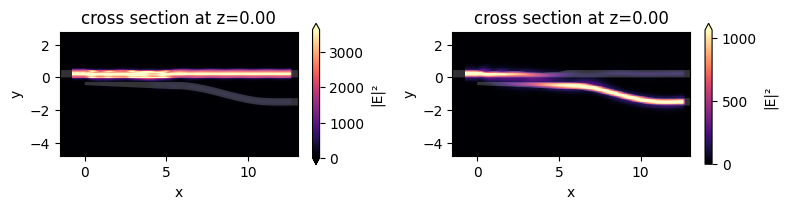

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2), tight_layout=True)
batch_results["TE"].plot_field("field", "E", "abs^2", ax=ax1)
batch_results["TM"].plot_field("field", "E", "abs^2", ax=ax2)
plt.show()

Plot the transmission spectra. 

[13:12:07] loading SimulationData from                             ]8;id=920928;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=857291;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#591\591]8;;\
           data\fdve-60c9fabe-eb20-4f01-be8f-d55ab1bc30f1v1.hdf5                

           loading SimulationData from                             ]8;id=184748;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=379542;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#591\591]8;;\
           data\fdve-3e4f0fdc-6b4a-468d-bc03-ef1f49167b76v1.hdf5                

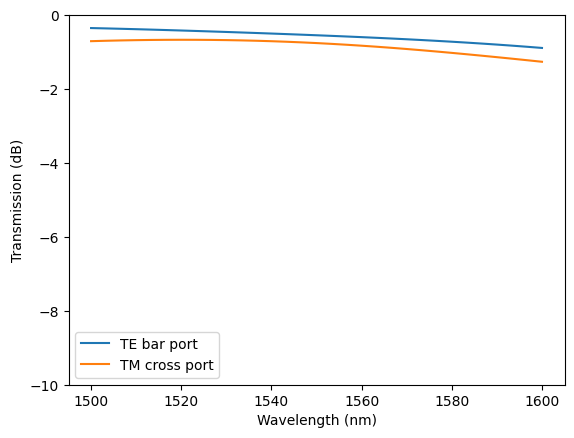

In [18]:
# extract transmission spectra to the bar and cross ports
P_TE_bar = np.abs(batch_results["TE"]["bar"].amps.sel(mode_index=0, direction="+")) ** 2
P_TM_cross = np.abs(batch_results["TM"]["cross"].amps.sel(mode_index=0, direction="+")) ** 2

# plot the spectra
plt.plot(ldas * 1e3, 10 * np.log10(P_TE_bar), label="TE bar port")
plt.plot(ldas * 1e3, 10 * np.log10(P_TM_cross), label="TM cross port")
plt.legend()
plt.ylabel("Transmission (dB)")
plt.xlabel("Wavelength (nm)")
plt.ylim(-10, 0)
plt.show()

## Closing Remark

The final design in this notebook achieves reasonable performance but is by no means the best design. A more intricate optimization scheme can be used to enhance the final result as demonstrated in the [publication](https://doi.org/10.1364/OE.408432).

The PSO optimizer from the [PySwarms](https://pyswarms.readthedocs.io/en/latest/index.html) library is a convenient plug-and-play tool but it has several limitations. For example, it does not work with discretized parameter space and does not support dynamic hyperparameters. Users should explore other options or even implement the optimizer manually when highly customized features are needed. 

Due to the large number of simulation runs, a PSO task can take a significant amount of time and FlexCredits. Users should have a good familiarity with Tidy3D before attempting to perform PSO to avoid making mistakes in the optimization and wasting credits. Running a smaller PSO task as a test and practice before a large PSO task is also highly recommended. 